<a href="https://colab.research.google.com/github/datadigger01/AI-Trade/blob/main/Kor_ITC_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests

url = "https://github.com/datadigger01/AI-Trade/raw/main/Data/Kor_ITC_by_year.csv"
response = requests.get(url)

# # Save the content to a local file
# with open("Kor_ITC_by_year.csv", "wb") as f:
#     f.write(response.content)


# Read the CSV data into a pandas DataFrame
df = pd.read_csv(url) # Read directly from the raw URL

# # Read the CSV into a pandas DataFrame
# df = pd.read_csv("Kor_ITC_by_year.csv")

# Display the first few rows of the DataFrame
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         129 non-null    float64
 1   balPayments  129 non-null    int64  
 2   expDlr       129 non-null    int64  
 3   expWgt       129 non-null    int64  
 4   impDlr       129 non-null    int64  
 5   impWgt       129 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 6.2 KB


None

,year,balPayments,expDlr,expWgt,impDlr,impWgt
0,2015.01,2909150931,9490450555,118164329,6581299624,91089942
1,2015.02,2586153194,8246231718,106768233,5660078524,82223236
2,2015.03,3296644684,9756890979,130305633,6460246295,83927084
3,2015.04,3295753981,9622910116,121908073,6327156135,78571766
4,2015.05,3869369309,9290169208,110060360,5420799899,81108478


In [ ]:
"""
한국 ITC 월별 수출액 예측을 위한 Feature Engineering 함수 모듈

데이터: 월별 ITC 수출입 데이터 (2015.01 ~ 2025.09, 129개월)
타겟: expDlr (수출액)

Window 크기 설정 근거:
- 총 129개월 데이터
- 월별 데이터 특성상 3개월(분기), 6개월(반기), 12개월(년) 주기 활용
- 최대 window: 24개월 (약 80% 데이터 보존)

사용 예시:
    df = pd.read_csv('Kor_ITC_by_year__2_.csv')
    df_with_features = create_all_itc_features(df)
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def preprocess_itc_data(df):
    """
    ITC 데이터 전처리

    Args:
        df: 원본 데이터프레임

    Returns:
        전처리된 데이터프레임
    """
    df = df.copy()

    # year 컬럼을 날짜로 변환
    df['Date'] = pd.to_datetime(df['year'].astype(str).str.replace('.', '-'), format='%Y-%m')

    # 날짜순 정렬
    df = df.sort_values('Date').reset_index(drop=True)

    print(f"✅ 데이터 전처리 완료")
    print(f"   기간: {df['Date'].min().strftime('%Y-%m')} ~ {df['Date'].max().strftime('%Y-%m')}")
    print(f"   총 {len(df)}개월")

    return df


def create_lag_features(df, target_col='expDlr', lags=[1, 2, 3, 6, 12]):
    """
    월별 수출액 및 관련 변수의 Lag Features 생성

    Args:
        df: 원본 데이터프레임
        target_col: 타겟 컬럼명 (기본: expDlr)
        lags: lag 기간 (개월 단위)

    Returns:
        lag feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 수출액 Lags
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # 수출중량 Lags (중요 보조 지표)
    for lag in [1, 2, 3, 6, 12]:
        df[f'expWgt_lag_{lag}'] = df['expWgt'].shift(lag)

    # 수입액 Lags (무역 연관성)
    for lag in [1, 2, 3, 6]:
        df[f'impDlr_lag_{lag}'] = df['impDlr'].shift(lag)

    # 무역수지 Lags
    for lag in [1, 2, 3, 6]:
        df[f'balPayments_lag_{lag}'] = df['balPayments'].shift(lag)

    return df


def create_growth_rate_features(df, target_col='expDlr', periods=[1, 3, 6, 12]):
    """
    월별 증가율 및 변화율 Features 생성

    Args:
        df: 원본 데이터프레임
        target_col: 타겟 컬럼명
        periods: 증가율 계산 기간 (개월)

    Returns:
        증가율 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 수출액 증가율 (MoM, QoQ, YoY)
    df['expDlr_mom'] = df[target_col].pct_change(1).shift(1)  # Month-over-Month
    df['expDlr_qoq'] = df[target_col].pct_change(3).shift(1)  # Quarter-over-Quarter
    df['expDlr_yoy'] = df[target_col].pct_change(12).shift(1)  # Year-over-Year

    # 다양한 기간의 증가율
    for period in periods:
        df[f'expDlr_growth_{period}m'] = df[target_col].pct_change(period).shift(1)

    # 수출액 절대 변화량
    df['expDlr_change_1m'] = (df[target_col] - df[target_col].shift(1)).shift(1)
    df['expDlr_change_3m'] = (df[target_col] - df[target_col].shift(3)).shift(1)
    df['expDlr_change_12m'] = (df[target_col] - df[target_col].shift(12)).shift(1)

    # 수출중량 증가율
    df['expWgt_mom'] = df['expWgt'].pct_change(1).shift(1)
    df['expWgt_yoy'] = df['expWgt'].pct_change(12).shift(1)

    # 수입액 증가율
    df['impDlr_mom'] = df['impDlr'].pct_change(1).shift(1)
    df['impDlr_yoy'] = df['impDlr'].pct_change(12).shift(1)

    return df


def create_moving_average_features(df, target_col='expDlr',
                                   windows=[3, 6, 12]):
    """
    이동평균 Features 생성

    Args:
        df: 원본 데이터프레임
        target_col: 타겟 컬럼명
        windows: 이동평균 윈도우 (개월 단위)
                3개월(분기), 6개월(반기), 12개월(년)

    Returns:
        이동평균 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 수출액 이동평균 (SMA)
    for window in windows:
        df[f'expDlr_sma_{window}'] = df[target_col].rolling(window=window).mean().shift(1)

    # 수출액 지수이동평균 (EMA)
    for window in [3, 6, 12]:
        df[f'expDlr_ema_{window}'] = df[target_col].ewm(span=window, adjust=False).mean().shift(1)

    # 이동평균 교차 (크로스오버)
    df['sma_3_6_diff'] = (df['expDlr_sma_3'] - df['expDlr_sma_6'])
    df['sma_6_12_diff'] = (df['expDlr_sma_6'] - df['expDlr_sma_12'])

    # 현재 가격 대비 이동평균 비율
    df['price_to_sma_3'] = (df[target_col] / df['expDlr_sma_3'].shift(-1)) - 1
    df['price_to_sma_6'] = (df[target_col] / df['expDlr_sma_6'].shift(-1)) - 1
    df['price_to_sma_12'] = (df[target_col] / df['expDlr_sma_12'].shift(-1)) - 1

    # 수출중량 이동평균
    for window in [3, 6, 12]:
        df[f'expWgt_sma_{window}'] = df['expWgt'].rolling(window=window).mean().shift(1)

    # 수입액 이동평균
    for window in [3, 6, 12]:
        df[f'impDlr_sma_{window}'] = df['impDlr'].rolling(window=window).mean().shift(1)

    return df


def create_volatility_features(df, target_col='expDlr', windows=[3, 6, 12]):
    """
    변동성 Features 생성

    Args:
        df: 원본 데이터프레임
        target_col: 타겟 컬럼명
        windows: 변동성 계산 윈도우 (개월 단위)

    Returns:
        변동성 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 수출액 표준편차 (변동성)
    monthly_return = df[target_col].pct_change(1)
    for window in windows:
        df[f'expDlr_volatility_{window}m'] = monthly_return.rolling(window=window).std().shift(1)

    # 수출액 변동계수 (CV = std / mean)
    for window in windows:
        rolling_mean = df[target_col].rolling(window=window).mean()
        rolling_std = df[target_col].rolling(window=window).std()
        df[f'expDlr_cv_{window}m'] = (rolling_std / rolling_mean).shift(1)

    # 수출액 범위 (max - min)
    for window in [3, 6, 12]:
        rolling_max = df[target_col].rolling(window=window).max()
        rolling_min = df[target_col].rolling(window=window).min()
        df[f'expDlr_range_{window}m'] = ((rolling_max - rolling_min) / rolling_min).shift(1)

    return df


def create_momentum_features(df, target_col='expDlr'):
    """
    모멘텀 지표 Features 생성 (RSI, 모멘텀)

    Args:
        df: 원본 데이터프레임
        target_col: 타겟 컬럼명

    Returns:
        모멘텀 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # RSI (Relative Strength Index)
    def calculate_rsi(data, period=12):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['expDlr_rsi_6'] = calculate_rsi(df[target_col], period=6).shift(1)
    df['expDlr_rsi_12'] = calculate_rsi(df[target_col], period=12).shift(1)

    # 모멘텀 (현재가 / N개월 전 가격 - 1)
    df['expDlr_momentum_3'] = (df[target_col] / df[target_col].shift(3) - 1).shift(1)
    df['expDlr_momentum_6'] = (df[target_col] / df[target_col].shift(6) - 1).shift(1)
    df['expDlr_momentum_12'] = (df[target_col] / df[target_col].shift(12) - 1).shift(1)

    # MACD (월별 데이터에 맞게 조정)
    ema_6 = df[target_col].ewm(span=6, adjust=False).mean()
    ema_12 = df[target_col].ewm(span=12, adjust=False).mean()
    df['expDlr_macd'] = (ema_6 - ema_12).shift(1)
    df['expDlr_macd_signal'] = df['expDlr_macd'].shift(-1).ewm(span=3, adjust=False).mean().shift(1)
    df['expDlr_macd_histogram'] = (df['expDlr_macd'] - df['expDlr_macd_signal'])

    return df


def create_trade_ratio_features(df):
    """
    무역 비율 관련 Features 생성

    Args:
        df: 원본 데이터프레임

    Returns:
        무역 비율 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 수출입 비율
    df['export_import_ratio'] = (df['expDlr'] / df['impDlr']).shift(1)

    # 무역수지 비율 (수출액 대비)
    df['balance_to_export'] = (df['balPayments'] / df['expDlr']).shift(1)

    # 단위당 가격 (달러/중량)
    df['export_unit_price'] = (df['expDlr'] / df['expWgt']).shift(1)
    df['import_unit_price'] = (df['impDlr'] / df['impWgt']).shift(1)

    # 단위당 가격 비율
    df['export_import_price_ratio'] = (df['export_unit_price'] / df['import_unit_price'].shift(-1))

    # 중량 대비 금액 비율
    df['expDlr_per_expWgt'] = (df['expDlr'] / df['expWgt']).shift(1)
    df['impDlr_per_impWgt'] = (df['impDlr'] / df['impWgt']).shift(1)

    # 이동평균 비율
    for window in [3, 6, 12]:
        df[f'export_import_ratio_ma{window}'] = (
            df['export_import_ratio'].shift(-1).rolling(window=window).mean().shift(1)
        )

    return df


def create_seasonal_features(df):
    """
    계절성 Features 생성 (월별 데이터 특화)

    Args:
        df: 원본 데이터프레임 (Date 컬럼 필수)

    Returns:
        계절성 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 기본 시간 특성
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year

    # 주기적 인코딩 (Cyclical encoding) - 월
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # 주기적 인코딩 - 분기
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    # 월별 더미 변수 (선택적 사용)
    for m in range(1, 13):
        df[f'is_month_{m}'] = (df['month'] == m).astype(int)

    # 분기별 더미 변수
    for q in range(1, 5):
        df[f'is_quarter_{q}'] = (df['quarter'] == q).astype(int)

    return df


def create_statistical_features(df, target_col='expDlr', window=12):
    """
    통계적 Features 생성

    Args:
        df: 원본 데이터프레임
        target_col: 타겟 컬럼명
        window: rolling 윈도우 크기

    Returns:
        통계 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Rolling Min/Max
    for window in [6, 12]:
        df[f'rolling_max_{window}m'] = df[target_col].rolling(window=window).max().shift(1)
        df[f'rolling_min_{window}m'] = df[target_col].rolling(window=window).min().shift(1)

        # 최대/최소값으로부터의 거리
        df[f'distance_from_max_{window}m'] = (
            (df[f'rolling_max_{window}m'] - df[target_col]) / df[f'rolling_max_{window}m']
        ).shift(-1)
        df[f'distance_from_min_{window}m'] = (
            (df[target_col] - df[f'rolling_min_{window}m']) / df[f'rolling_min_{window}m']
        ).shift(-1)

    # Percentile Rank
    df['percentile_rank_12m'] = df[target_col].rolling(window=12).apply(
        lambda x: pd.Series(x).rank().iloc[-1] / len(x), raw=False
    ).shift(1)

    # Z-score (표준화 점수)
    for window in [6, 12]:
        rolling_mean = df[target_col].rolling(window=window).mean()
        rolling_std = df[target_col].rolling(window=window).std()
        df[f'zscore_{window}m'] = ((df[target_col] - rolling_mean) / rolling_std).shift(1)

    return df


def create_trend_features(df, target_col='expDlr'):
    """
    추세 관련 Features 생성

    Args:
        df: 원본 데이터프레임
        target_col: 타겟 컬럼명

    Returns:
        추세 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 연속 증가/감소 개월 수
    df['consecutive_increase'] = 0
    df['consecutive_decrease'] = 0

    for i in range(1, len(df)):
        if df[target_col].iloc[i] > df[target_col].iloc[i-1]:
            df.loc[i, 'consecutive_increase'] = df.loc[i-1, 'consecutive_increase'] + 1
            df.loc[i, 'consecutive_decrease'] = 0
        elif df[target_col].iloc[i] < df[target_col].iloc[i-1]:
            df.loc[i, 'consecutive_decrease'] = df.loc[i-1, 'consecutive_decrease'] + 1
            df.loc[i, 'consecutive_increase'] = 0

    df['consecutive_increase'] = df['consecutive_increase'].shift(1)
    df['consecutive_decrease'] = df['consecutive_decrease'].shift(1)

    # 상승/하락 추세 (이동평균 기울기)
    for window in [3, 6]:
        df[f'trend_slope_{window}m'] = df[f'expDlr_sma_{window}'].diff(1).shift(1)

    return df


def create_interaction_features(df):
    """
    상호작용 Features 생성

    Args:
        df: 원본 데이터프레임

    Returns:
        상호작용 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 수출액 * 수출중량 (규모 지표)
    df['expDlr_x_expWgt'] = (df['expDlr'] * df['expWgt']).shift(1)

    # 증가율 * 변동성 (리스크 지표)
    if 'expDlr_mom' in df.columns and 'expDlr_volatility_3m' in df.columns:
        df['growth_x_volatility'] = (df['expDlr_mom'] * df['expDlr_volatility_3m'])

    # 무역수지 * 수출입비율
    if 'balPayments' in df.columns and 'export_import_ratio' in df.columns:
        df['balance_x_ratio'] = (df['balPayments'] * df['export_import_ratio']).shift(1)

    return df


def create_all_itc_features(df, target_col='expDlr', include_target=True, remove_nan=True):
    """
    모든 Feature를 한번에 생성하는 메인 함수

    Args:
        df: 원본 데이터프레임 (year, expDlr, expWgt, impDlr, impWgt, balPayments 컬럼 필수)
        target_col: 타겟 컬럼명 (기본: expDlr)
        include_target: 타겟 변수 (다음달 수출액) 포함 여부
        remove_nan: 결측치 제거 여부 (기본값: True)

    Returns:
        모든 feature가 추가된 데이터프레임

    Example:
        >>> df = pd.read_csv('Kor_ITC_by_year__2_.csv')
        >>> df_with_features = create_all_itc_features(df, remove_nan=True)
        >>> print(f"생성된 feature 수: {len(df_with_features.columns) - 6}")
    """
    df = df.copy()

    print("\n" + "="*80)
    print("ITC 수출액 예측을 위한 Feature Engineering")
    print("="*80)

    # 데이터 전처리
    df = preprocess_itc_data(df)

    # 타겟 변수 생성
    if include_target:
        df['target_next_month'] = df[target_col].shift(-1)
        print(f"\n✅ 타겟 변수 생성: target_next_month (다음달 {target_col})")

    print("\nFeature Engineering 시작...")

    # 1. Lag Features
    print("  [1/10] Lag Features 생성 중...")
    df = create_lag_features(df, target_col=target_col)

    # 2. Growth Rate Features
    print("  [2/10] Growth Rate Features 생성 중...")
    df = create_growth_rate_features(df, target_col=target_col)

    # 3. Moving Average Features
    print("  [3/10] Moving Average Features 생성 중...")
    df = create_moving_average_features(df, target_col=target_col)

    # 4. Volatility Features
    print("  [4/10] Volatility Features 생성 중...")
    df = create_volatility_features(df, target_col=target_col)

    # 5. Momentum Features
    print("  [5/10] Momentum Features 생성 중...")
    df = create_momentum_features(df, target_col=target_col)

    # 6. Trade Ratio Features
    print("  [6/10] Trade Ratio Features 생성 중...")
    df = create_trade_ratio_features(df)

    # 7. Seasonal Features
    print("  [7/10] Seasonal Features 생성 중...")
    df = create_seasonal_features(df)

    # 8. Statistical Features
    print("  [8/10] Statistical Features 생성 중...")
    df = create_statistical_features(df, target_col=target_col)

    # 9. Trend Features
    print("  [9/10] Trend Features 생성 중...")
    df = create_trend_features(df, target_col=target_col)

    # 10. Interaction Features
    print("  [10/10] Interaction Features 생성 중...")
    df = create_interaction_features(df)

    print("\n✅ Feature Engineering 완료!")

    # Feature 개수 출력
    original_cols = ['year', 'Date', 'balPayments', 'expDlr', 'expWgt', 'impDlr', 'impWgt']
    target_cols = ['target_next_month'] if include_target else []
    feature_cols = [col for col in df.columns
                   if col not in original_cols and col not in target_cols]

    print("\n" + "="*80)
    print("Feature 생성 요약")
    print("="*80)
    print(f"원본 컬럼 수: {len(original_cols)}")
    print(f"생성된 Feature 수: {len(feature_cols)}")
    print(f"총 컬럼 수: {len(df.columns)}")
    print(f"\n결측치 제거 전 데이터 크기: {len(df)}개월")

    # 결측치 제거
    if remove_nan:
        nan_count_before = df.isnull().any(axis=1).sum()
        df_clean = df.dropna().reset_index(drop=True)
        print(f"결측치가 있는 행 수: {nan_count_before}개월")
        print(f"결측치 제거 후 데이터 크기: {len(df_clean)}개월 ✅")

        # 데이터 손실률 계산
        loss_rate = (nan_count_before / len(df)) * 100
        print(f"데이터 손실률: {loss_rate:.1f}%")

        if loss_rate > 30:
            print(f"\n⚠️  경고: 데이터 손실률이 {loss_rate:.1f}%로 높습니다!")
            print("   → Window 크기를 줄이는 것을 권장합니다.")
        else:
            print(f"\n✅ 데이터 손실률이 {loss_rate:.1f}%로 적절합니다.")

        return df_clean
    else:
        nan_count = df.isnull().any(axis=1).sum()
        print(f"결측치가 있는 행 수: {nan_count}개월 (제거하지 않음)")
        return df


# ============================================================================
# 사용 예시
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("한국 ITC 월별 수출액 예측 - Feature Engineering")
    print("="*80)

    # 데이터 로드
    #df = pd.read_csv('Kor_ITC_by_year__2_.csv')

    print(f"\n원본 데이터: {df.shape}")
    print(f"기간: {df['year'].iloc[0]} ~ {df['year'].iloc[-1]}")

    # Feature Engineering (결측치 자동 제거)
    df_with_features = create_all_itc_features(
        df,
        target_col='expDlr',
        include_target=True,
        remove_nan=True
    )

    # 결과 저장
    output_path = 'itc_export_features_clean.csv'
    df_with_features.to_csv(output_path, index=False)
    print(f"\n💾 저장 완료: {output_path}")

    # Feature 목록 출력
    print("\n" + "="*80)
    print("생성된 Feature 목록 (카테고리별)")
    print("="*80)

    feature_categories = {
        'Lag Features': [col for col in df_with_features.columns if 'lag' in col],
        'Growth Rate Features': [col for col in df_with_features.columns if any(x in col for x in ['mom', 'qoq', 'yoy', 'growth', 'change'])],
        'Moving Average Features': [col for col in df_with_features.columns if any(x in col for x in ['sma', 'ema', 'diff'])],
        'Volatility Features': [col for col in df_with_features.columns if any(x in col for x in ['volatility', 'cv', 'range'])],
        'Momentum Features': [col for col in df_with_features.columns if any(x in col for x in ['rsi', 'momentum', 'macd'])],
        'Trade Ratio Features': [col for col in df_with_features.columns if any(x in col for x in ['ratio', 'unit_price', 'per_'])],
        'Seasonal Features': [col for col in df_with_features.columns if any(x in col for x in ['month', 'quarter', 'is_month', 'is_quarter'])],
        'Statistical Features': [col for col in df_with_features.columns if any(x in col for x in ['rolling_max', 'rolling_min', 'distance', 'percentile', 'zscore'])],
        'Trend Features': [col for col in df_with_features.columns if any(x in col for x in ['consecutive', 'trend_slope'])],
        'Interaction Features': [col for col in df_with_features.columns if '_x_' in col]
    }

    for category, features in feature_categories.items():
        if features:
            print(f"\n{category} ({len(features)}개):")
            for feat in features[:5]:  # 각 카테고리에서 처음 5개만 출력
                print(f"  - {feat}")
            if len(features) > 5:
                print(f"  ... 외 {len(features) - 5}개")

    # 샘플 데이터 확인
    print("\n" + "="*80)
    print("샘플 데이터 (최근 5개월)")
    print("="*80)
    display_cols = ['Date', 'expDlr', 'target_next_month', 'expDlr_lag_1',
                   'expDlr_mom', 'expDlr_sma_3', 'export_import_ratio']
    print(df_with_features[display_cols].tail())

    print("\n" + "="*80)
    print("💡 Window 크기 설정 요약")
    print("="*80)
    print("""
    ✅ 적용된 Window 크기:

    - Lag Features: 1, 2, 3, 6, 12개월
      → 전월, 분기, 반기, 전년 대비 비교

    - Moving Average: 3, 6, 12개월
      → 분기 평균, 반기 평균, 연간 평균

    - Volatility: 3, 6, 12개월
      → 단기, 중기, 장기 변동성

    - 최대 Window: 12개월
      → 129개월 데이터에서 약 90% 데이터 보존

    📊 데이터 특성:
    - 총 데이터: 129개월 (2015.01 ~ 2025.09)
    - 월별 데이터 특성상 계절성(3, 6, 12개월) 고려
    - 무역 데이터의 분기별, 연도별 패턴 반영
    """)


한국 ITC 월별 수출액 예측 - Feature Engineering

원본 데이터: (129, 6)
기간: 2015.01 ~ 2025.09

ITC 수출액 예측을 위한 Feature Engineering
✅ 데이터 전처리 완료
   기간: 2015-01 ~ 2025-09
   총 129개월

✅ 타겟 변수 생성: target_next_month (다음달 expDlr)

Feature Engineering 시작...
  [1/10] Lag Features 생성 중...
  [2/10] Growth Rate Features 생성 중...
  [3/10] Moving Average Features 생성 중...
  [4/10] Volatility Features 생성 중...
  [5/10] Momentum Features 생성 중...
  [6/10] Trade Ratio Features 생성 중...
  [7/10] Seasonal Features 생성 중...
  [8/10] Statistical Features 생성 중...
  [9/10] Trend Features 생성 중...
  [10/10] Interaction Features 생성 중...

✅ Feature Engineering 완료!

Feature 생성 요약
원본 컬럼 수: 7
생성된 Feature 수: 116
총 컬럼 수: 124

결측치 제거 전 데이터 크기: 129개월
결측치가 있는 행 수: 14개월
결측치 제거 후 데이터 크기: 115개월 ✅
데이터 손실률: 10.9%

✅ 데이터 손실률이 10.9%로 적절합니다.

💾 저장 완료: itc_export_features_clean.csv

생성된 Feature 목록 (카테고리별)

Lag Features (18개):
  - expDlr_lag_1
  - expDlr_lag_2
  - expDlr_lag_3
  - expDlr_lag_6
  - expDlr_lag_12
  ... 외 13개

Growth Rate Features (18개

In [ ]:
display(df_with_features.info())
display(df_with_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Columns: 124 entries, year to balance_x_ratio
dtypes: datetime64[ns](1), float64(99), int32(3), int64(21)
memory usage: 110.2 KB


None

,year,balPayments,expDlr,expWgt,impDlr,impWgt,Date,target_next_month,expDlr_lag_1,expDlr_lag_2,...,percentile_rank_12m,zscore_6m,zscore_12m,consecutive_increase,consecutive_decrease,trend_slope_3m,trend_slope_6m,expDlr_x_expWgt,growth_x_volatility,balance_x_ratio
0,2016,3038602883,9254764628,134537275,6216161745,72241812,2016-01-01,7.121449e+09,7.544967e+09,8.763204e+09,...,0.083333,-1.582644,-2.085172,0.0,3.0,-1.615323e+08,-8.782759e+07,8.653054e+17,-0.005482,3.519768e+09
1,2016,1671172052,7121448880,114028401,5450276828,62963890,2016-02-01,8.671841e+09,9.254765e+09,7.544967e+09,...,0.583333,0.147136,0.161072,1.0,0.0,-9.940066e+08,-2.449440e+08,1.245111e+18,0.043661,4.326770e+09
2,2016,2319192322,8671840637,135573872,6352648315,72185560,2016-03-01,7.545820e+09,7.121449e+09,9.254765e+09,...,0.083333,-1.305264,-2.087310,0.0,1.0,-2.766196e+07,4.136795e+07,8.120474e+17,-0.055755,2.488079e+09
3,2016,1549565225,7545819593,119557614,5996254368,65596418,2016-04-01,7.895811e+09,8.671841e+09,7.121449e+09,...,0.250000,0.244099,-0.310838,1.0,0.0,-5.472516e+08,-3.543919e+08,1.175675e+18,0.056906,3.030307e+09
4,2016,2621264050,7895811125,128070523,5274547075,67809734,2016-05-01,8.491689e+09,7.545820e+09,8.671841e+09,...,0.250000,-0.706778,-1.292404,0.0,1.0,3.756244e+08,-3.091911e+08,9.021602e+17,-0.030536,2.115273e+09


XGBoost 시계열 예측 모델 학습 시작
한국 ITC 월별 수출액 예측

[1단계] 데이터 로드 및 기본 탐색
--------------------------------------------------------------------------------
데이터 shape: (115, 124)

결측치 개수: 0 개

데이터 타입:
float64           99
int64             21
int32              3
datetime64[ns]     1
Name: count, dtype: int64

[2단계] 시계열 특성 파악
--------------------------------------------------------------------------------
날짜 범위: 2016-01-01 00:00:00 ~ 2025-08-01 00:00:00
총 115개월 데이터

target_next_month (다음달 수출액) 통계:
  - 평균: $9,876,798,175
  - 표준편차: $1,367,880,249
  - 최소값: $7,121,448,880
  - 최대값: $14,081,465,832

expDlr (현재 수출액) 통계:
  - 평균: $9,848,954,836
  - 표준편차: $1,347,338,554
  - 최소값: $7,121,448,880
  - 최대값: $14,081,465,832

[3단계] Feature 선택 및 전처리
--------------------------------------------------------------------------------
제외할 컬럼: ['year', 'Date', 'target_next_month']

Feature 개수: 121
샘플 개수: 115

Feature 목록 (처음 20개):
  1. balPayments
  2. expDlr
  3. expWgt
  4. impDlr
  5. impWgt
  6. expDlr_lag_1
  7. expDlr

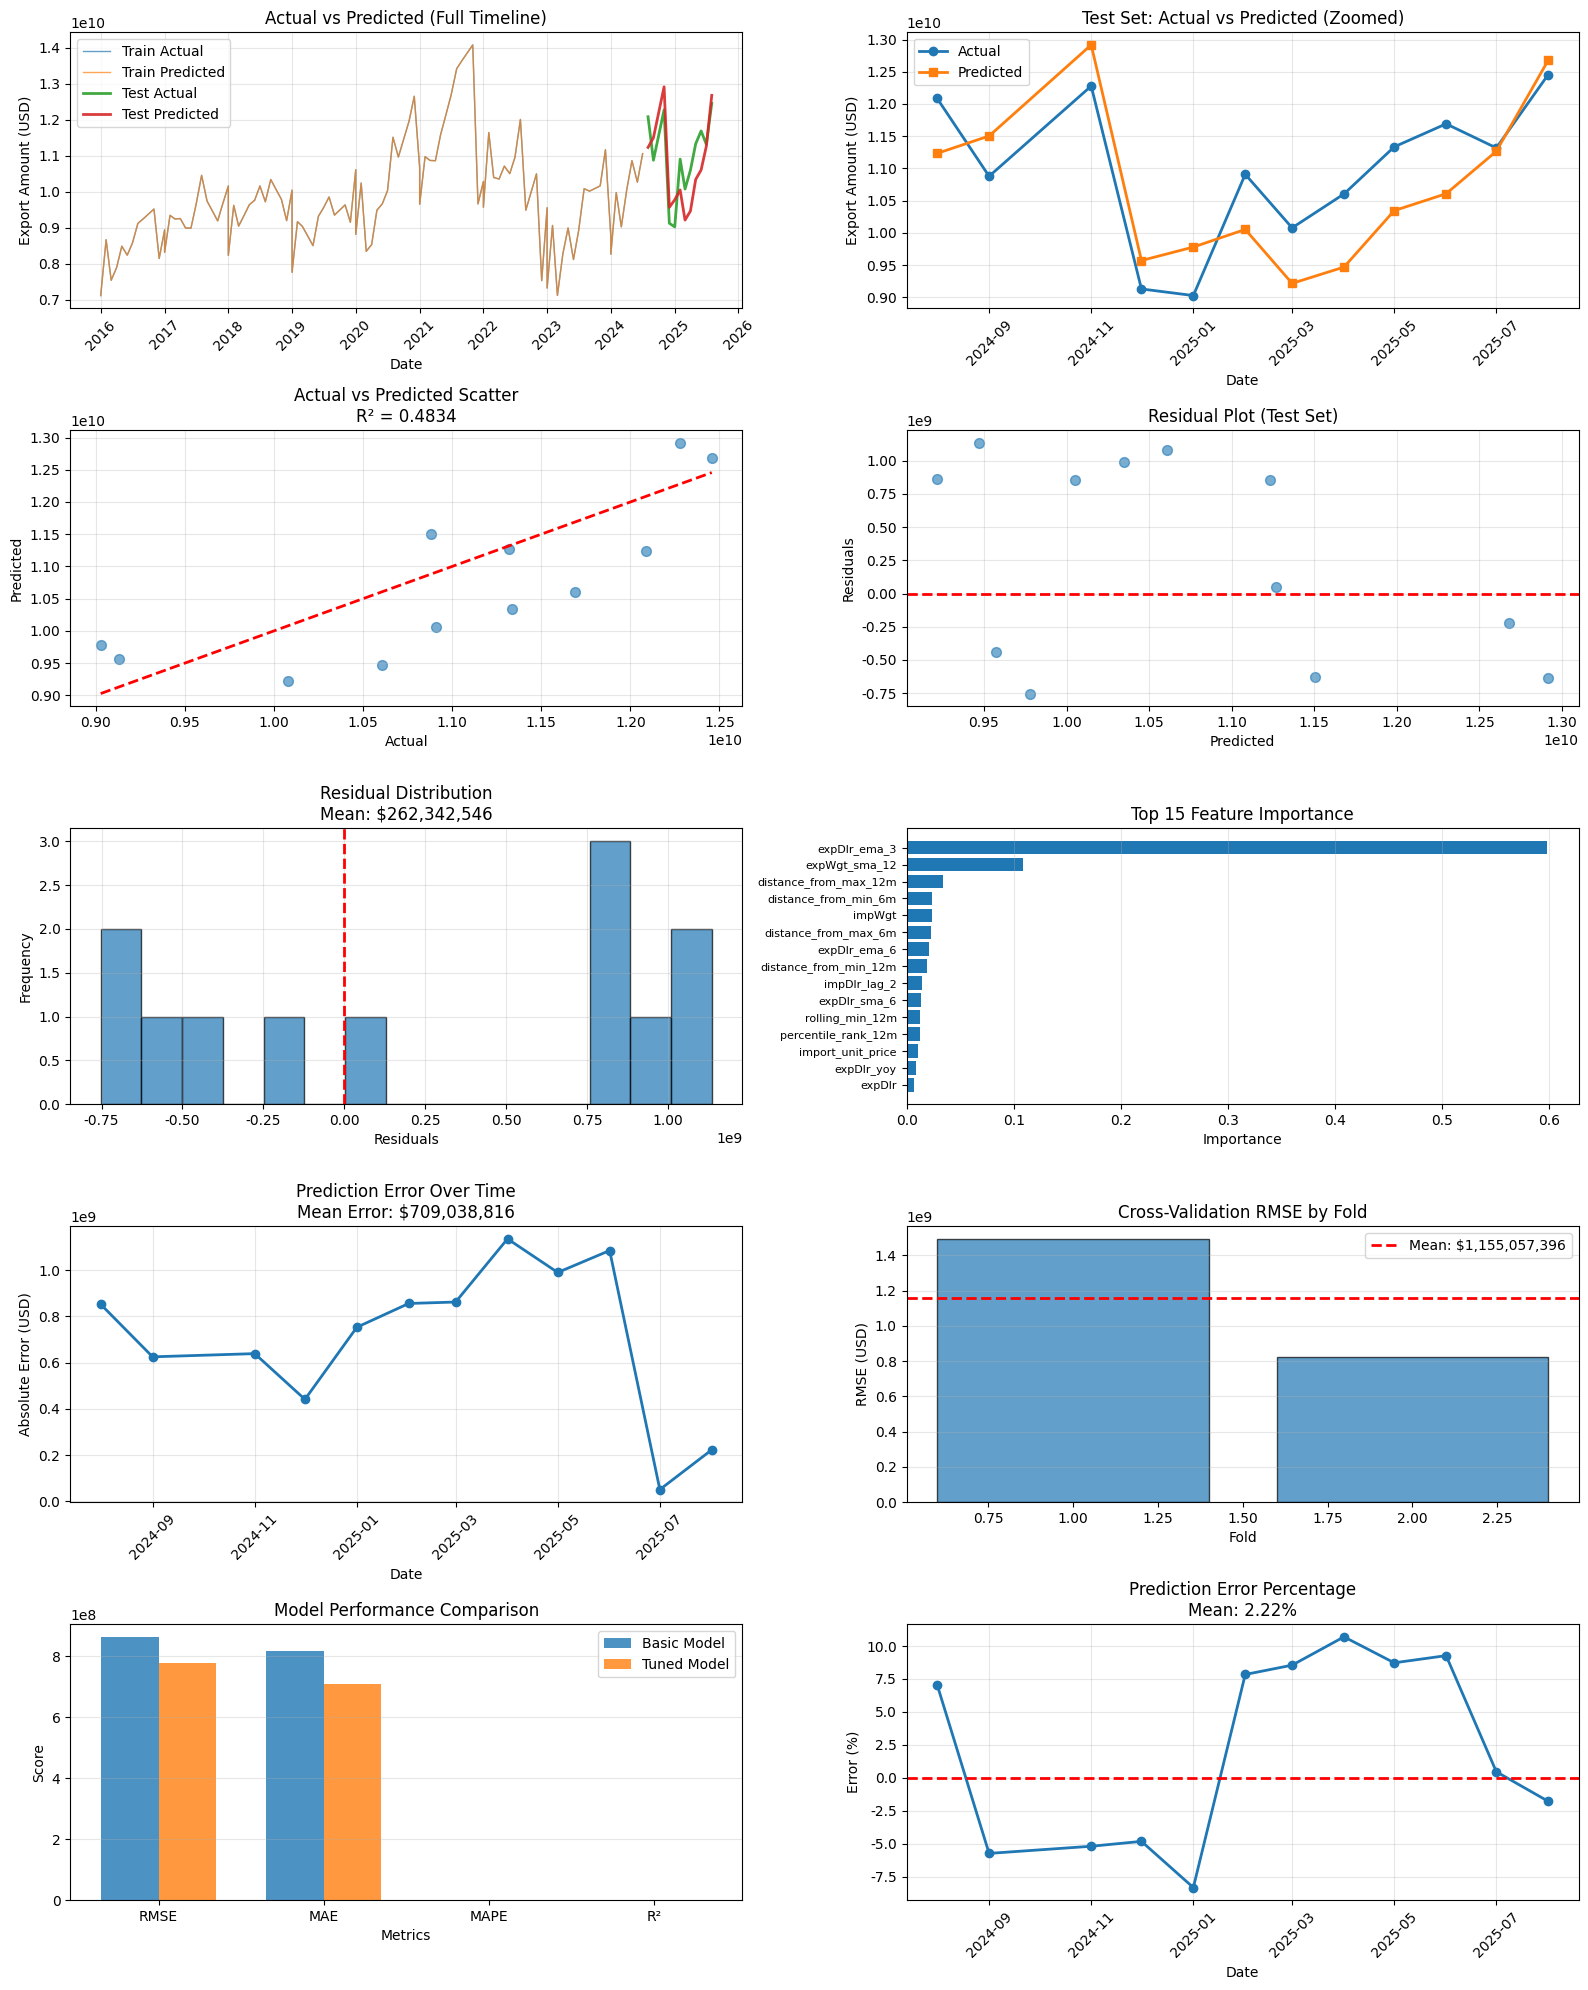

In [ ]:
"""
XGBoost 시계열 예측 모델
한국 ITC 월별 수출액(expDlr) 예측을 위한 전체 프로세스

데이터: itc_export_features_clean.csv
타겟: target_next_month (다음달 수출액)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 80)
print("XGBoost 시계열 예측 모델 학습 시작")
print("한국 ITC 월별 수출액 예측")
print("=" * 80)

# ============================================================================
# 1. 데이터 로드 및 기본 탐색
# ============================================================================
print("\n[1단계] 데이터 로드 및 기본 탐색")
print("-" * 80)

# 데이터 로드
df_target = df_with_features

print(f"데이터 shape: {df_target.shape}")
print(f"\n결측치 개수: {df_target.isnull().sum().sum()} 개")
print(f"\n데이터 타입:")
print(df_target.dtypes.value_counts())

# ============================================================================
# 2. 시계열 특성 파악
# ============================================================================
print("\n[2단계] 시계열 특성 파악")
print("-" * 80)

# Date를 datetime으로 변환
df_target['Date'] = pd.to_datetime(df_target['Date'])
print(f"날짜 범위: {df_target['Date'].min()} ~ {df_target['Date'].max()}")
print(f"총 {len(df_target)}개월 데이터")

# Target 변수 기본 통계
print(f"\ntarget_next_month (다음달 수출액) 통계:")
print(f"  - 평균: ${df_target['target_next_month'].mean():,.0f}")
print(f"  - 표준편차: ${df_target['target_next_month'].std():,.0f}")
print(f"  - 최소값: ${df_target['target_next_month'].min():,.0f}")
print(f"  - 최대값: ${df_target['target_next_month'].max():,.0f}")

# 현재 수출액(expDlr) 통계
print(f"\nexpDlr (현재 수출액) 통계:")
print(f"  - 평균: ${df_target['expDlr'].mean():,.0f}")
print(f"  - 표준편차: ${df_target['expDlr'].std():,.0f}")
print(f"  - 최소값: ${df_target['expDlr'].min():,.0f}")
print(f"  - 최대값: ${df_target['expDlr'].max():,.0f}")

# ============================================================================
# 3. Feature 선택 및 전처리
# ============================================================================
print("\n[3단계] Feature 선택 및 전처리")
print("-" * 80)

# 제외할 컬럼 정의 (year, Date, target_next_month)
columns_to_drop = ['year', 'Date', 'target_next_month']
print(f"제외할 컬럼: {columns_to_drop}")

# Feature와 Target 분리
X = df_target.drop(columns_to_drop, axis=1)
y = df_target['target_next_month']

print(f"\nFeature 개수: {X.shape[1]}")
print(f"샘플 개수: {len(y)}")

# Feature 목록 출력 (처음 20개만)
print(f"\nFeature 목록 (처음 20개):")
for i, col in enumerate(X.columns[:20], 1):
    print(f"  {i}. {col}")
print(f"  ... 외 {len(X.columns) - 20}개")

# 데이터 타입 확인 및 변환
print(f"\nFeature 데이터 타입 변환...")
X = X.astype(np.float64)
print("✓ 모든 Feature를 float64로 변환 완료")

# Inf 값 처리
inf_count = np.isinf(X.values).sum()
if inf_count > 0:
    print(f"⚠️  Inf 값 {inf_count}개 발견 - 0으로 대체")
    X = X.replace([np.inf, -np.inf], 0)
else:
    print("✓ Inf 값 없음")

# ============================================================================
# 4. 데이터 분할 (시계열 순서 유지)
# ============================================================================
print("\n[4단계] 데이터 분할 (Train/Test)")
print("-" * 80)

# Train/Test 분할 (shuffle=False로 시계열 순서 유지)
# 월별 데이터이므로 10% 테스트 = 약 11-12개월
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

print(f"Train set: {X_train.shape[0]} 개월 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} 개월 ({X_test.shape[0]/len(X)*100:.1f}%)")

# 인덱스를 사용하여 날짜 정보 추출
train_dates = df_target.loc[y_train.index, 'Date']
test_dates = df_target.loc[y_test.index, 'Date']

print(f"Train 기간: {train_dates.iloc[0].strftime('%Y-%m')} ~ {train_dates.iloc[-1].strftime('%Y-%m')}")
print(f"Test 기간: {test_dates.iloc[0].strftime('%Y-%m')} ~ {test_dates.iloc[-1].strftime('%Y-%m')}")

# ============================================================================
# 5. 기본 XGBoost 모델 학습
# ============================================================================
print("\n[5단계] 기본 XGBoost 모델 학습")
print("-" * 80)

# 기본 XGBoost 모델
xgb_basic = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("모델 학습 중...")
xgb_basic.fit(X_train, y_train)
print("✓ 학습 완료!")

# ============================================================================
# 6. 예측 수행
# ============================================================================
print("\n[6단계] 예측 수행")
print("-" * 80)

# Train과 Test 예측
y_train_pred = xgb_basic.predict(X_train)
y_test_pred = xgb_basic.predict(X_test)

print("✓ 예측 완료!")

# ============================================================================
# 7. 모델 평가
# ============================================================================
print("\n[7단계] 모델 평가")
print("-" * 80)

def calculate_mape(y_true, y_pred, eps=1e-8):
    """MAPE 계산 함수"""
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

# Train 성능
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = calculate_mape(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test 성능
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = calculate_mape(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("📊 Train Set 성능:")
print(f"  - RMSE: ${train_rmse:,.0f}")
print(f"  - MAE: ${train_mae:,.0f}")
print(f"  - MAPE: {train_mape:.2f}%")
print(f"  - R² Score: {train_r2:.4f}")

print("\n📊 Test Set 성능:")
print(f"  - RMSE: ${test_rmse:,.0f}")
print(f"  - MAE: ${test_mae:,.0f}")
print(f"  - MAPE: {test_mape:.2f}%")
print(f"  - R² Score: {test_r2:.4f}")

# ============================================================================
# 8. Feature Importance 분석
# ============================================================================
print("\n[8단계] Feature Importance 분석")
print("-" * 80)

# Feature Importance 계산
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_basic.feature_importances_
}).sort_values('importance', ascending=False)

print("\n상위 20개 중요 Feature:")
print(feature_importance.head(20).to_string(index=False))

# Feature Importance 저장
feature_importance.to_csv('/content/sample_data/xgb_feature_importance.csv', index=False)
print("\n✓ Feature importance를 'xgb_feature_importance.csv'에 저장했습니다.")

# ============================================================================
# 9. 하이퍼파라미터 튜닝
# ============================================================================
print("\n[9단계] 하이퍼파라미터 튜닝 (RandomizedSearchCV)")
print("-" * 80)

# 파라미터 그리드 정의
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

print("RandomizedSearchCV 실행 중... (시간이 걸릴 수 있습니다)")
print(f"테스트할 조합 수: 20개 (랜덤 샘플링)")

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=20,  # 20개 조합만 테스트
    cv=TimeSeriesSplit(n_splits=3),  # 시계열 교차검증
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print("\n✓ 튜닝 완료!")
print(f"\n최적 파라미터:")
for param, value in xgb_random.best_params_.items():
    print(f"  - {param}: {value}")

# 최적 모델로 예측
y_train_pred_tuned = xgb_random.predict(X_train)
y_test_pred_tuned = xgb_random.predict(X_test)

# 튜닝 후 성능
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)
test_mape_tuned = calculate_mape(y_test, y_test_pred_tuned)
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)

print("\n📊 튜닝 후 Test Set 성능:")
print(f"  - RMSE: ${test_rmse_tuned:,.0f} (개선: ${test_rmse - test_rmse_tuned:,.0f})")
print(f"  - MAE: ${test_mae_tuned:,.0f} (개선: ${test_mae - test_mae_tuned:,.0f})")
print(f"  - MAPE: {test_mape_tuned:.2f}% (개선: {test_mape - test_mape_tuned:.2f}%)")
print(f"  - R² Score: {test_r2_tuned:.4f} (개선: {test_r2_tuned - test_r2:.4f})")

# ============================================================================
# 10. 시계열 교차 검증
# ============================================================================
print("\n[10단계] 시계열 교차 검증 (TimeSeriesSplit)")
print("-" * 80)

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=2)
cv_scores = []

print("2-Fold 시계열 교차 검증 수행 중...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 최적 모델로 학습
    cv_model = XGBRegressor(**xgb_random.best_params_, random_state=42, n_jobs=-1)
    cv_model.fit(X_cv_train, y_cv_train)

    # 검증 세트 예측
    y_cv_pred = cv_model.predict(X_cv_val)
    cv_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_scores.append(cv_rmse)

    print(f"  Fold {fold} - RMSE: ${cv_rmse:,.0f}")

print(f"\n평균 CV RMSE: ${np.mean(cv_scores):,.0f} (±${np.std(cv_scores):,.0f})")

# ============================================================================
# 11. 결과 시각화
# ============================================================================
print("\n[11단계] 결과 시각화")
print("-" * 80)

# 그림 크기 설정
fig = plt.figure(figsize=(16, 20))

# 1) 실제값 vs 예측값 비교 (Train + Test)
ax1 = plt.subplot(5, 2, 1)
plt.plot(train_dates, y_train.values, label='Train Actual', alpha=0.7, linewidth=1)
plt.plot(train_dates, y_train_pred_tuned, label='Train Predicted', alpha=0.7, linewidth=1)
plt.plot(test_dates, y_test.values, label='Test Actual', alpha=0.9, linewidth=2)
plt.plot(test_dates, y_test_pred_tuned, label='Test Predicted', alpha=0.9, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Export Amount (USD)')
plt.title('Actual vs Predicted (Full Timeline)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2) Test 구간만 확대
ax2 = plt.subplot(5, 2, 2)
plt.plot(test_dates, y_test.values, 'o-', label='Actual', linewidth=2, markersize=6)
plt.plot(test_dates, y_test_pred_tuned, 's-', label='Predicted', linewidth=2, markersize=6)
plt.xlabel('Date')
plt.ylabel('Export Amount (USD)')
plt.title('Test Set: Actual vs Predicted (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3) Scatter Plot (Test Set)
ax3 = plt.subplot(5, 2, 3)
plt.scatter(y_test, y_test_pred_tuned, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted Scatter\nR² = {test_r2_tuned:.4f}')
plt.grid(True, alpha=0.3)

# 4) 잔차 분석 (Test Set)
ax4 = plt.subplot(5, 2, 4)
residuals = y_test - y_test_pred_tuned
plt.scatter(y_test_pred_tuned, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.grid(True, alpha=0.3)

# 5) 잔차 분포
ax5 = plt.subplot(5, 2, 5)
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution\nMean: ${residuals.mean():,.0f}')
plt.grid(True, alpha=0.3)

# 6) Feature Importance (상위 15개)
ax6 = plt.subplot(5, 2, 6)
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=8)
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# 7) 예측 오차 시계열 (Test Set)
ax7 = plt.subplot(5, 2, 7)
errors = np.abs(y_test - y_test_pred_tuned)
plt.plot(test_dates, errors, 'o-', linewidth=2, markersize=6)
plt.xlabel('Date')
plt.ylabel('Absolute Error (USD)')
plt.title(f'Prediction Error Over Time\nMean Error: ${errors.mean():,.0f}')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 8) 교차 검증 결과
ax8 = plt.subplot(5, 2, 8)
plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, edgecolor='black')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', linewidth=2,
           label=f'Mean: ${np.mean(cv_scores):,.0f}')
plt.xlabel('Fold')
plt.ylabel('RMSE (USD)')
plt.title('Cross-Validation RMSE by Fold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 9) 성능 비교 (기본 모델 vs 튜닝 모델)
ax9 = plt.subplot(5, 2, 9)
metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
basic_scores = [test_rmse, test_mae, test_mape, test_r2]
tuned_scores = [test_rmse_tuned, test_mae_tuned, test_mape_tuned, test_r2_tuned]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, basic_scores, width, label='Basic Model', alpha=0.8)
bars2 = plt.bar(x + width/2, tuned_scores, width, label='Tuned Model', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 10) 예측 오차 비율 (Test Set)
ax10 = plt.subplot(5, 2, 10)
error_pct = ((y_test - y_test_pred_tuned) / y_test) * 100
plt.plot(test_dates, error_pct, 'o-', linewidth=2, markersize=6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Error (%)')
plt.title(f'Prediction Error Percentage\nMean: {error_pct.mean():.2f}%')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('/content/sample_data/xgb_model_results.png', dpi=300, bbox_inches='tight')
print("✓ 시각화 결과를 'xgb_model_results.png'에 저장했습니다.")
# plt.show()  # 서버 환경에서는 주석 처리

# ============================================================================
# 12. 모델 저장
# ============================================================================
print("\n[12단계] 모델 저장")
print("-" * 80)

# 최적 모델 저장
joblib.dump(xgb_random.best_estimator_, '/content/sample_data/xgb_model_tuned.pkl')
print("✓ 튜닝된 모델을 'xgb_model_tuned.pkl'에 저장했습니다.")

# 기본 모델도 저장
joblib.dump(xgb_basic, '/content/sample_data/xgb_model_basic.pkl')
print("✓ 기본 모델을 'xgb_model_basic.pkl'에 저장했습니다.")

# ============================================================================
# 13. 결과 요약 저장
# ============================================================================
print("\n[13단계] 결과 요약 저장")
print("-" * 80)

summary = {
    'model': ['Basic XGBoost', 'Tuned XGBoost'],
    'test_rmse': [test_rmse, test_rmse_tuned],
    'test_mae': [test_mae, test_mae_tuned],
    'test_mape': [test_mape, test_mape_tuned],
    'test_r2': [test_r2, test_r2_tuned],
    'train_rmse': [train_rmse, np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))],
    'cv_mean_rmse': [None, np.mean(cv_scores)],
    'cv_std_rmse': [None, np.std(cv_scores)]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('/content/sample_data/xgb_model_summary.csv', index=False)
print("✓ 모델 성능 요약을 'xgb_model_summary.csv'에 저장했습니다.")

# ============================================================================
# 14. 예측 결과 저장
# ============================================================================
print("\n[14단계] 예측 결과 저장")
print("-" * 80)

# Test 데이터 예측 결과 저장
predictions_df = pd.DataFrame({
    'Date': test_dates.values,
    'Actual': y_test.values,
    'Predicted': y_test_pred_tuned,
    'Error': y_test.values - y_test_pred_tuned,
    'Error_Pct': ((y_test.values - y_test_pred_tuned) / y_test.values) * 100
})

predictions_df.to_csv('/content/sample_data/xgb_predictions.csv', index=False)
print("✓ 예측 결과를 'xgb_predictions.csv'에 저장했습니다.")

# ============================================================================
# 최종 요약
# ============================================================================
print("\n" + "=" * 80)
print("✅ 모든 프로세스 완료!")
print("=" * 80)

print("\n생성된 파일:")
print("  1. xgb_model_basic.pkl - 기본 XGBoost 모델")
print("  2. xgb_model_tuned.pkl - 튜닝된 XGBoost 모델")
print("  3. xgb_feature_importance.csv - Feature 중요도 순위")
print("  4. xgb_model_summary.csv - 모델 성능 요약")
print("  5. xgb_model_results.png - 결과 시각화 차트")
print("  6. xgb_predictions.csv - 테스트 데이터 예측 결과")

print("\n" + "=" * 80)
print("최종 Test Set 성능 (튜닝 모델):")
print("=" * 80)
print(f"  - RMSE: ${test_rmse_tuned:,.0f}")
print(f"  - MAE: ${test_mae_tuned:,.0f}")
print(f"  - MAPE: {test_mape_tuned:.2f}%")
print(f"  - R² Score: {test_r2_tuned:.4f}")

print("\n교차 검증 성능:")
print(f"  - 평균 CV RMSE: ${np.mean(cv_scores):,.0f}")
print(f"  - 표준편차: ${np.std(cv_scores):,.0f}")

print("\n상위 5개 중요 Feature:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print("\n" + "=" * 80)
print("🎯 모델 학습 완료! 예측 모델을 사용하여 다음달 수출액을 예측할 수 있습니다.")
print("=" * 80)

In [ ]:
"""
itc_export_features_clean(1).csv 기준
- label: target_next_month
- feature: year, date 제외한 나머지 수치 컬럼
에 대해 RandomForest + SHAP으로 feature 중요도 산출
"""

import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor # Added import
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from SHAP1 import shap_analysis_model, get_global_feature_importance, plot_shap_summary, plot_shap_bar # Assuming SHAP1 is a local file with these functions

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import os

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')


# ============================================================================
# Part 2: Basic SHAP Analysis Functions
# ============================================================================

def shap_analysis_model(model, X_train, X_test, feature_names, model_type='auto'):
    """
    모델에 대한 SHAP 분석 수행 (RandomForest 또는 XGBoost)

    Args:
        model: 학습된 모델
        X_train: 학습 데이터 (배경 데이터로 사용)
        X_test: 테스트 데이터
        feature_names: Feature 이름 리스트
        model_type: 'randomforest', 'xgboost', 또는 'auto'

    Returns:
        shap_values: SHAP 값
        explainer: SHAP explainer 객체
    """
    print("\n" + "="*80)
    print(f"SHAP Analysis - {model_type.upper()}")
    print("="*80)

    print("\n[1] SHAP Explainer 생성 중...")

    # TreeExplainer 사용 (트리 기반 모델에 최적화)
    if model_type in ['randomforest', 'auto']:
        # RandomForest의 경우 배경 데이터 샘플링
        background = shap.sample(X_train, min(100, len(X_train)))
        explainer = shap.TreeExplainer(model, background)
    else:  # xgboost
        # XGBoost는 feature_perturbation='tree_path_dependent' 사용하여 호환성 개선
        try:
            explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
        except Exception as e:
            print(f"   ⚠️ TreeExplainer 초기화 실패, 대안 방법 시도...")
            # 대안: 배경 데이터를 사용하여 초기화
            background = shap.sample(X_train, min(100, len(X_train)))
            explainer = shap.TreeExplainer(model, background, feature_perturbation='tree_path_dependent')

    print("[2] SHAP 값 계산 중...")
    print(f"   테스트 샘플 수: {len(X_test)}")

    # SHAP 값 계산
    shap_values = explainer.shap_values(X_test)

    print(f"✅ SHAP 값 계산 완료!")
    print(f"   Shape: {shap_values.shape}")

    # expected_value가 배열인 경우 처리
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        expected_val = explainer.expected_value[0] if len(explainer.expected_value) > 0 else explainer.expected_value
    else:
        expected_val = explainer.expected_value

    print(f"   Base value (평균 예측): {expected_val:.4f}")

    return shap_values, explainer


# ============================================================================
# Part 3: Visualization Functions
# ============================================================================

def plot_shap_summary(shap_values, X_test, feature_names, save_path=None):
    """
    SHAP Summary Plot: 전역 Feature Importance + 방향성
    가장 중요한 시각화! 각 feature의 영향도와 방향을 한눈에 파악
    """
    print("\n[시각화] SHAP Summary Plot 생성 중...")

    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test,
                     feature_names=feature_names,
                     plot_type="dot",
                     show=False)
    plt.title('SHAP Summary Plot - Feature Impact on Predictions',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()

def plot_shap_bar(shap_values, X_test, feature_names, top_n=20, save_path=None):
    """
    SHAP Bar Plot: 평균 절대 SHAP 값 (전역 중요도)
    Feature Importance보다 더 정확한 중요도 측정
    """
    print(f"\n[시각화] SHAP Bar Plot (Top {top_n}) 생성 중...")

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test,
                     feature_names=feature_names,
                     plot_type="bar",
                     max_display=top_n,
                     show=False)
    plt.title(f'Top {top_n} Features by Mean |SHAP Value|',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()


def plot_shap_waterfall(shap_values, explainer, X_test, sample_idx=0,
                        feature_names=None, save_path=None):
    """
    SHAP Waterfall Plot: 개별 예측 설명
    특정 예측이 왜 그렇게 나왔는지 단계별로 설명
    """
    print(f"\n[시각화] SHAP Waterfall Plot (Sample {sample_idx}) 생성 중...")

    # DataFrame인 경우와 array인 경우 모두 처리
    if hasattr(X_test, 'iloc'):
        sample_data = X_test.iloc[sample_idx].values
    else:
        sample_data = X_test[sample_idx]

    # expected_value가 배열인 경우 처리
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[0] if len(explainer.expected_value) > 0 else explainer.expected_value
    else:
        base_value = explainer.expected_value

    # SHAP Explanation 객체 생성
    shap_explanation = shap.Explanation(
        values=shap_values[sample_idx],
        base_values=base_value,
        data=sample_data,
        feature_names=feature_names
    )

    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap_explanation, show=False)
    plt.title(f'SHAP Waterfall - Individual Prediction (Sample {sample_idx})',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()


def plot_shap_dependence(shap_values, X_test, feature_name,
                        feature_names, interaction_feature='auto',
                        save_path=None):
    """
    SHAP Dependence Plot: Feature 값과 SHAP 값의 관계
    특정 feature가 예측에 미치는 영향을 그 값의 범위에 따라 시각화
    """
    print(f"\n[시각화] SHAP Dependence Plot - {feature_name} 생성 중...")

    plt.figure(figsize=(10, 6))

    shap.dependence_plot(
        feature_name,
        shap_values,
        X_test,
        feature_names=feature_names,
        interaction_index=interaction_feature,
        show=False
    )

    plt.title(f'SHAP Dependence Plot - {feature_name}',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()


# ============================================================================
# Part 4: Analysis Functions
# ============================================================================

def get_global_feature_importance(shap_values, feature_names):
    """
    SHAP 기반 전역 Feature Importance 계산
    각 feature의 평균 절대 SHAP 값 반환
    """
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values('mean_abs_shap', ascending=False)

    return importance_df


def analyze_individual_prediction(shap_values, explainer, X_test, sample_idx,
                                  feature_names, top_n=10):
    """
    특정 예측에 대한 상세 분석
    어떤 feature가 이 예측에 가장 크게 기여했는지 분석
    """
    print(f"\n" + "="*80)
    print(f"개별 예측 분석 - Sample {sample_idx}")
    print("="*80)

    # 샘플의 SHAP 값
    sample_shap = shap_values[sample_idx]

    # 샘플의 Feature 값
    if hasattr(X_test, 'iloc'):
        sample_features = X_test.iloc[sample_idx].values
    else:
        sample_features = X_test[sample_idx]

    # DataFrame 생성
    contribution_df = pd.DataFrame({
        'feature': feature_names,
        'feature_value': sample_features,
        'shap_value': sample_shap,
        'abs_shap': np.abs(sample_shap)
    }).sort_values('abs_shap', ascending=False)

    # expected_value가 배열인 경우 처리
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[0] if len(explainer.expected_value) > 0 else explainer.expected_value
    else:
        base_value = explainer.expected_value

    # 예측값 계산
    prediction = base_value + sample_shap.sum()

    print(f"\n기준값 (Base Value): {base_value:.4f}")
    print(f"예측값: {prediction:.4f}")
    print(f"SHAP 합계: {sample_shap.sum():+.4f}")

    print(f"\nTop {top_n} 기여 Features:")
    print("-"*80)
    print(f"{'Feature':<30s} {'Value':>10s} {'SHAP':>12s} {'영향':<10s}")
    print("-"*80)

    for idx, row in contribution_df.head(top_n).iterrows():
        direction = "↑ 증가" if row['shap_value'] > 0 else "↓ 감소"
        print(f"{row['feature']:<30s} {row['feature_value']:>10.4f} "
              f"{row['shap_value']:>+12.4f} {direction:<10s}")

    return contribution_df


def compare_shap_vs_feature_importance(shap_values, model, feature_names):
    """
    SHAP 중요도와 전통적 Feature Importance 비교
    둘의 차이를 시각화하여 더 정확한 중요도 파악
    """
    print("\n" + "="*80)
    print("SHAP vs Traditional Feature Importance 비교")
    print("="*80)

    # SHAP 기반 중요도
    shap_importance = np.abs(shap_values).mean(axis=0)

    # 전통적 Feature Importance
    if hasattr(model, 'feature_importances_'):
        traditional_importance = model.feature_importances_
    else:
        print("⚠️  모델이 feature_importances_ 속성을 지원하지 않습니다")
        return None

    # 데이터프레임 생성
    comparison_df = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': shap_importance,
        'traditional_importance': traditional_importance
    })

    # 정규화 (0-1 스케일)
    comparison_df['shap_normalized'] = (
        comparison_df['shap_importance'] / comparison_df['shap_importance'].max()
    )
    comparison_df['traditional_normalized'] = (
        comparison_df['traditional_importance'] /
        comparison_df['traditional_importance'].max()
    )

    # 차이 계산
    comparison_df['difference'] = (
        comparison_df['shap_normalized'] - comparison_df['traditional_normalized']
    )

    comparison_df = comparison_df.sort_values('shap_importance', ascending=False)

    # Top 20 출력
    print("\nTop 20 Features 비교:")
    print("-"*80)
    print(f"{'Feature':<30s} {'SHAP':>10s} {'Trad':>10s} {'차이':>10s}")
    print("-"*80)

    for idx, row in comparison_df.head(20).iterrows():
        print(f"{row['feature']:<30s} "
              f"{row['shap_normalized']:>10.4f} "
              f"{row['traditional_normalized']:>10.4f} "
              f"{row['difference']:>+10.4f}")

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # Plot 1: 상위 20개 비교
    top_20 = comparison_df.head(20)
    x = np.arange(len(top_20))
    width = 0.35

    axes[0].barh(x - width/2, top_20['shap_normalized'], width,
                label='SHAP Importance', alpha=0.8)
    axes[0].barh(x + width/2, top_20['traditional_normalized'], width,
                label='Traditional Importance', alpha=0.8)
    axes[0].set_yticks(x)
    axes[0].set_yticklabels(top_20['feature'])
    axes[0].set_xlabel('Normalized Importance')
    axes[0].set_title('Top 20 Features: SHAP vs Traditional',
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')

    # Plot 2: 차이가 큰 순서대로
    sorted_by_diff = comparison_df.reindex(
        comparison_df['difference'].abs().sort_values(ascending=False).index
    ).head(20)

    colors = ['red' if x < 0 else 'green' for x in sorted_by_diff['difference']]
    axes[1].barh(range(len(sorted_by_diff)), sorted_by_diff['difference'],
                color=colors, alpha=0.6)
    axes[1].set_yticks(range(len(sorted_by_diff)))
    axes[1].set_yticklabels(sorted_by_diff['feature'])
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[1].set_xlabel('Difference (SHAP - Traditional)')
    axes[1].set_title('Top 20 Features by Importance Difference',
                     fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    return comparison_df

# ============================================================================
# Part 5: Multi-step Specific Functions
# ============================================================================

def shap_analysis_multistep_direct(models_dict, X_train, X_test, feature_names):
    """
    Direct Multi-step 방법의 7개 모델에 대한 SHAP 분석

    Args:
        models_dict: {day: model} 형태의 딕셔너리 (1-7일)
        X_train, X_test: Feature 데이터
        feature_names: Feature 이름 리스트

    Returns:
        shap_values_dict: {day: shap_values} 딕셔너리
        explainers_dict: {day: explainer} 딕셔너리
    """
    print("\n" + "="*80)
    print("Multi-step Direct 모델 SHAP 분석")
    print("="*80)

    shap_values_dict = {}
    explainers_dict = {}

    for day in sorted(models_dict.keys()):
        print(f"\n{'='*80}")
        print(f"Day {day} 모델 SHAP 분석")
        print('='*80)

        model = models_dict[day]
        shap_values, explainer = shap_analysis_model(
            model, X_train, X_test, feature_names, model_type='xgboost'
        )

        shap_values_dict[day] = shap_values
        explainers_dict[day] = explainer

    print("\n" + "="*80)
    print("✅ 모든 날짜의 SHAP 분석 완료!")
    print("="*80)

    return shap_values_dict, explainers_dict


def plot_shap_comparison_across_days(shap_values_dict, feature_names,
                                     top_n=15, save_path=None):
    """
    예측일별 Feature Importance 비교
    각 예측일에 따라 어떤 feature가 더 중요해지는지 시각화
    """
    print("\n" + "="*80)
    print("예측일별 SHAP Importance 비교")
    print("="*80)

    # 각 날짜별 평균 절대 SHAP 값 계산
    importance_by_day = {}
    for day, shap_values in shap_values_dict.items():
        importance_by_day[day] = np.abs(shap_values).mean(axis=0)

    # DataFrame 생성
    importance_df = pd.DataFrame(importance_by_day, index=feature_names)
    importance_df.columns = [f'Day {d}' for d in importance_df.columns]

    # 전체 평균 중요도로 정렬
    importance_df['mean'] = importance_df.mean(axis=1)
    importance_df = importance_df.sort_values('mean', ascending=False)

    # Top N 선택
    top_features = importance_df.head(top_n)
    top_features = top_features.drop('mean', axis=1)

    # 시각화
    fig, ax = plt.subplots(figsize=(14, 10))

    # Heatmap
    sns.heatmap(top_features, annot=True, fmt='.3f', cmap='YlOrRd',
               cbar_kws={'label': 'Mean |SHAP Value|'}, ax=ax)

    ax.set_title(f'Top {top_n} Features: SHAP Importance Across Forecast Days',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Forecast Day', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()

    # 결과 출력
    print("\n예측일별 Top 5 중요 Features:")
    print("-"*80)
    for col in top_features.columns:
        print(f"\n{col}:")
        day_importance = top_features[col].sort_values(ascending=False).head(5)
        for idx, (feature, value) in enumerate(day_importance.items(), 1):
            print(f"  {idx}. {feature:<30s}: {value:.4f}")

    return fig, importance_df


# ============================================================================
# Part 6: Complete Analysis Wrapper
# ============================================================================

def complete_shap_analysis(model, X_train, X_test, feature_names,
                          model_type='randomforest',
                          sample_indices=None,
                          top_features=None,
                          output_dir='shap_results'):
    """
    완전한 SHAP 분석 파이프라인
    모든 분석과 시각화를 한번에 수행

    Args:
        model: 학습된 모델
        X_train, X_test: Feature 데이터
        feature_names: Feature 이름 리스트
        model_type: 'randomforest' 또는 'xgboost'
        sample_indices: 개별 분석할 샘플 인덱스 리스트
        top_features: dependence plot을 그릴 주요 feature 리스트
        output_dir: 결과 저장 디렉토리
    """
    print("\n" + "="*80)
    print("Complete SHAP Analysis Pipeline")
    print("="*80)

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 1. SHAP 값 계산
    shap_values, explainer = shap_analysis_model(
        model, X_train, X_test, feature_names, model_type
    )

    # 2. 전역 중요도 분석
    global_importance = get_global_feature_importance(shap_values, feature_names)

    print("\n" + "="*80)
    print("Global Feature Importance (Top 20)")
    print("="*80)
    print(global_importance.head(20).to_string(index=False))

    # 3. 시각화
    print("\n" + "="*80)
    print("시각화 생성 중...")
    print("="*80)

    # Summary plot
    plot_shap_summary(
        shap_values, X_test, feature_names,
        save_path=f'{output_dir}/shap_summary.png'
    )

    # Bar plot
    plot_shap_bar(
        shap_values, X_test, feature_names, top_n=20,
        save_path=f'{output_dir}/shap_bar.png'
    )

    # 개별 예측 분석
    if sample_indices is None:
        sample_indices = [0, len(X_test)//4, len(X_test)//2]

    for idx in sample_indices:
        if idx < len(X_test):
            plot_shap_waterfall(
                shap_values, explainer, X_test, sample_idx=idx,
                feature_names=feature_names,
                save_path=f'{output_dir}/shap_waterfall_sample{idx}.png'
            )

            analyze_individual_prediction(
                shap_values, explainer, X_test, idx,
                feature_names, top_n=10
            )

    # Dependence plots (상위 feature들)
    if top_features is None:
        top_features = global_importance.head(5)['feature'].tolist()

    for feature in top_features:
        try:
            plot_shap_dependence(
                shap_values, X_test, feature, feature_names,
                interaction_feature='auto',
                save_path=f'{output_dir}/shap_dependence_{feature}.png'
            )
        except Exception as e:
            print(f"⚠️  {feature} dependence plot 생성 실패: {str(e)}")

    # 4. 전통적 중요도와 비교
    comparison_df = compare_shap_vs_feature_importance(
        shap_values, model, feature_names
    )

    # 5. 결과 저장
    global_importance.to_csv(f'{output_dir}/shap_global_importance.csv', index=False)
    if comparison_df is not None:
        comparison_df.to_csv(f'{output_dir}/shap_vs_traditional_comparison.csv', index=False)

    print("\n" + "="*80)
    print("✅ Complete SHAP Analysis 완료!")
    print(f"✅ 결과 저장 위치: {output_dir}/")
    print("="*80)

    # 결과 반환
    results = {
        'shap_values': shap_values,
        'explainer': explainer,
        'global_importance': global_importance,
        'comparison_df': comparison_df
    }

    return results



SHAP Analysis - ITC Export Example

Complete SHAP Analysis Pipeline

SHAP Analysis - XGBOOST

[1] SHAP Explainer 생성 중...
[2] SHAP 값 계산 중...
   테스트 샘플 수: 12
✅ SHAP 값 계산 완료!
   Shape: (12, 121)
   Base value (평균 예측): 9747924992.0000

Global Feature Importance (Top 20)
              feature  mean_abs_shap
         expDlr_ema_3    432537984.0
distance_from_min_12m    322728000.0
 distance_from_max_6m    250173840.0
distance_from_max_12m    214198352.0
 distance_from_min_6m    203298896.0
         expDlr_ema_6    119293608.0
               expDlr     92087680.0
               impDlr     58688752.0
         expDlr_lag_1     52033076.0
        expWgt_sma_12     37880612.0
        expDlr_sma_12     35230532.0
           expWgt_yoy     32936042.0
       rolling_min_6m     24830446.0
    expDlr_change_12m     20268808.0
         impDlr_lag_1     18042946.0
         expDlr_sma_6     17725042.0
         impDlr_sma_6     17007086.0
               impWgt     16781232.0
    import_unit_price     13

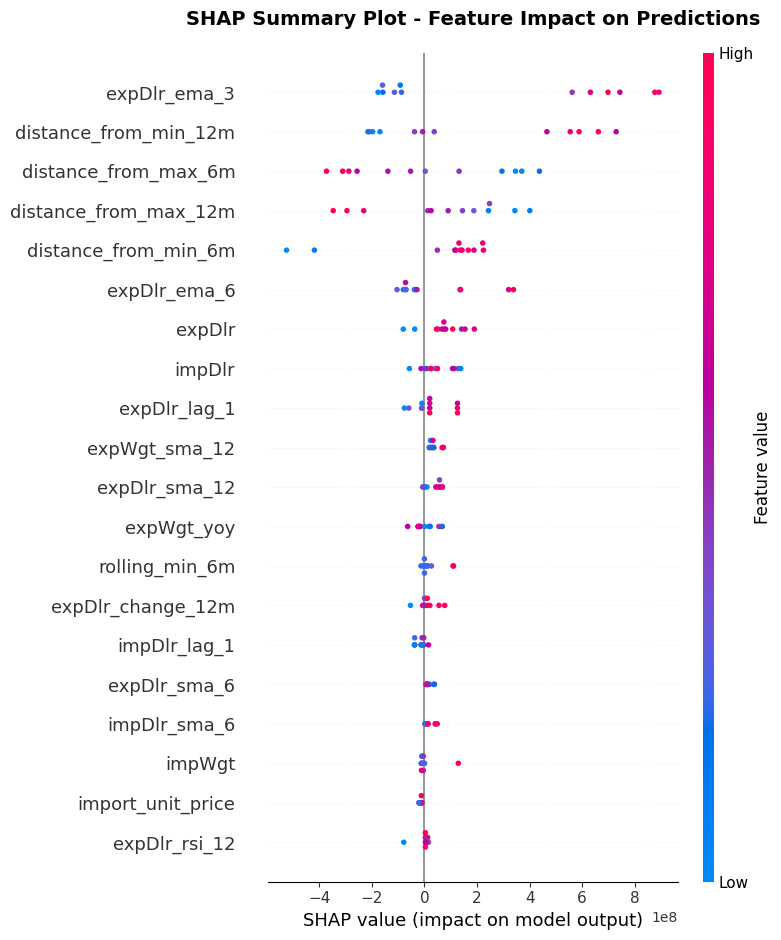


[시각화] SHAP Bar Plot (Top 20) 생성 중...
✅ 저장 완료: shap_results/shap_bar.png


<Figure size 640x480 with 0 Axes>

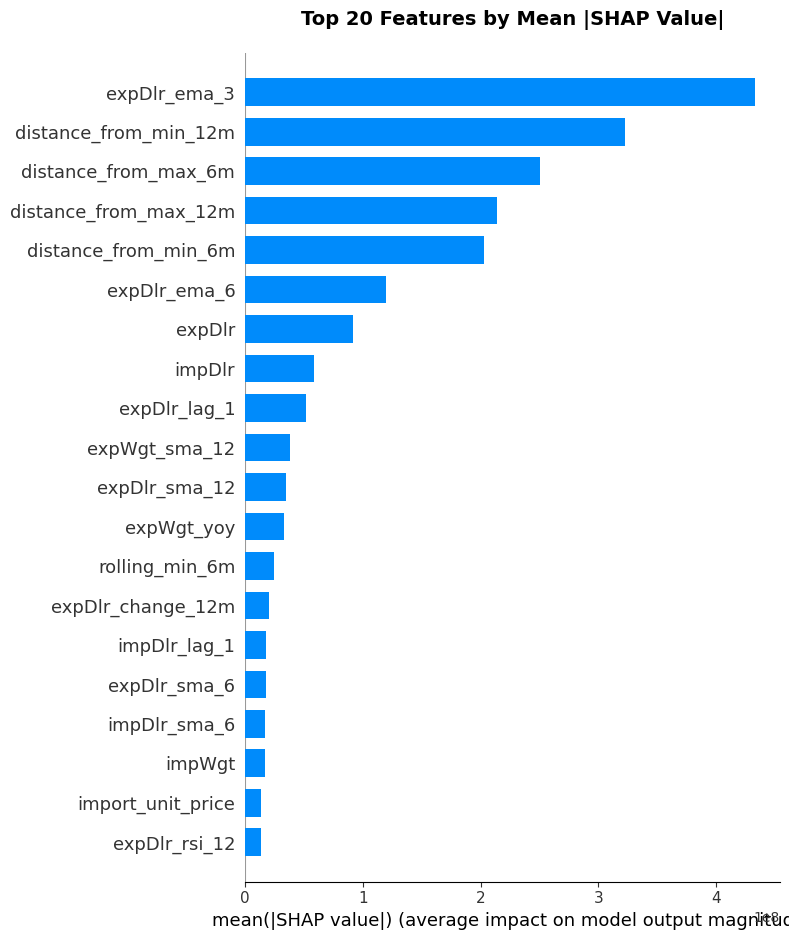


[시각화] SHAP Waterfall Plot (Sample 0) 생성 중...
✅ 저장 완료: shap_results/shap_waterfall_sample0.png


<Figure size 640x480 with 0 Axes>

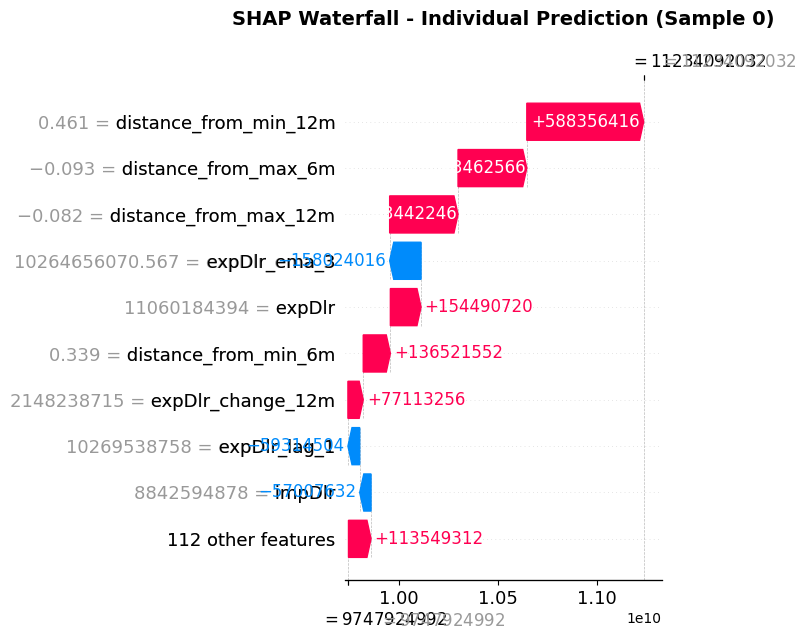


개별 예측 분석 - Sample 0

기준값 (Base Value): 9747924992.0000
예측값: 11234092032.0000
SHAP 합계: +1486166784.0000

Top 10 기여 Features:
--------------------------------------------------------------------------------
Feature                             Value         SHAP 영향        
--------------------------------------------------------------------------------
distance_from_min_12m              0.4614 +588356416.0000 ↑ 증가      
distance_from_max_6m              -0.0927 +346256672.0000 ↑ 증가      
distance_from_max_12m             -0.0819 +344224672.0000 ↑ 증가      
expDlr_ema_3                   10264656070.5674 -158024016.0000 ↓ 감소      
expDlr                         11060184394.0000 +154490720.0000 ↑ 증가      
distance_from_min_6m               0.3387 +136521552.0000 ↑ 증가      
expDlr_change_12m              2148238715.0000 +77113256.0000 ↑ 증가      
expDlr_lag_1                   10269538758.0000 -59314504.0000 ↓ 감소      
impDlr                         8842594878.0000 -57007632.0000 ↓ 감소      
e

<Figure size 640x480 with 0 Axes>

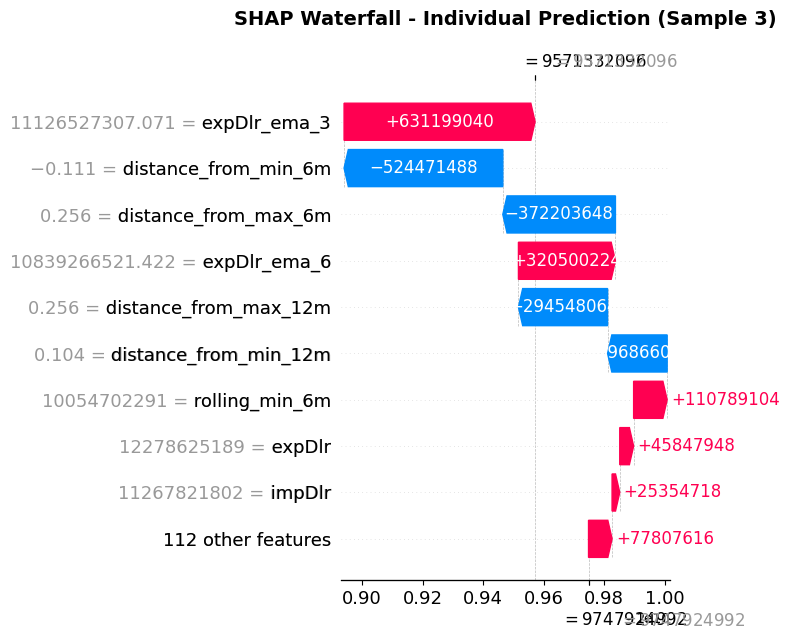


개별 예측 분석 - Sample 3

기준값 (Base Value): 9747924992.0000
예측값: 9571332096.0000
SHAP 합계: -176593024.0000

Top 10 기여 Features:
--------------------------------------------------------------------------------
Feature                             Value         SHAP 영향        
--------------------------------------------------------------------------------
expDlr_ema_3                   11126527307.0709 +631199040.0000 ↑ 증가      
distance_from_min_6m              -0.1109 -524471488.0000 ↓ 감소      
distance_from_max_6m               0.2564 -372203648.0000 ↓ 감소      
expDlr_ema_6                   10839266521.4224 +320500224.0000 ↑ 증가      
distance_from_max_12m              0.2564 -294548064.0000 ↓ 감소      
distance_from_min_12m              0.1040 -196866032.0000 ↓ 감소      
rolling_min_6m                 10054702291.0000 +110789104.0000 ↑ 증가      
expDlr                         12278625189.0000 +45847948.0000 ↑ 증가      
impDlr                         11267821802.0000 +25354718.0000 ↑ 증가      


<Figure size 640x480 with 0 Axes>

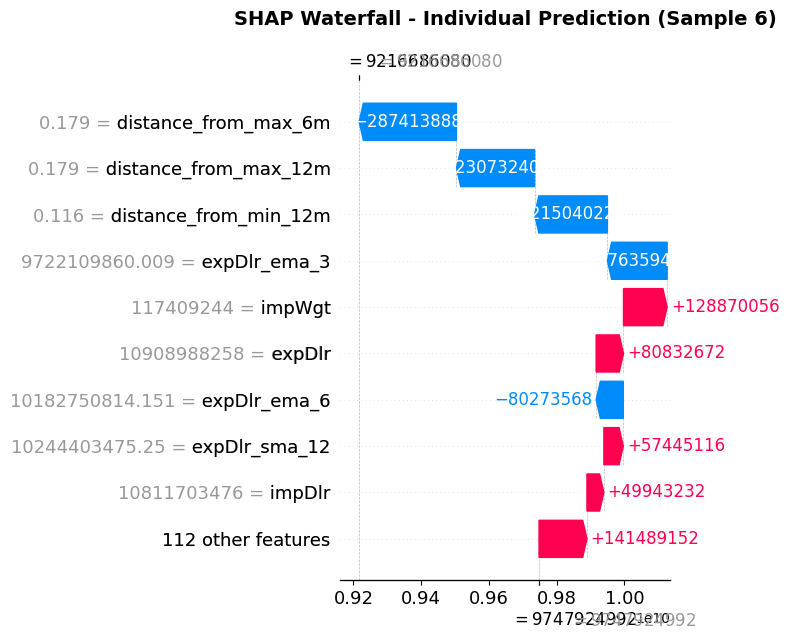


개별 예측 분석 - Sample 6

기준값 (Base Value): 9747924992.0000
예측값: 9216686080.0000
SHAP 합계: -531238464.0000

Top 10 기여 Features:
--------------------------------------------------------------------------------
Feature                             Value         SHAP 영향        
--------------------------------------------------------------------------------
distance_from_max_6m               0.1792 -287413888.0000 ↓ 감소      
distance_from_max_12m              0.1792 -230732400.0000 ↓ 감소      
distance_from_min_12m              0.1164 -215040224.0000 ↓ 감소      
expDlr_ema_3                   9722109860.0089 -176359424.0000 ↓ 감소      
impWgt                         117409244.0000 +128870056.0000 ↑ 증가      
expDlr                         10908988258.0000 +80832672.0000 ↑ 증가      
expDlr_ema_6                   10182750814.1510 -80273568.0000 ↓ 감소      
expDlr_sma_12                  10244403475.2500 +57445116.0000 ↑ 증가      
impDlr                         10811703476.0000 +49943232.0000 ↑ 증가      

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

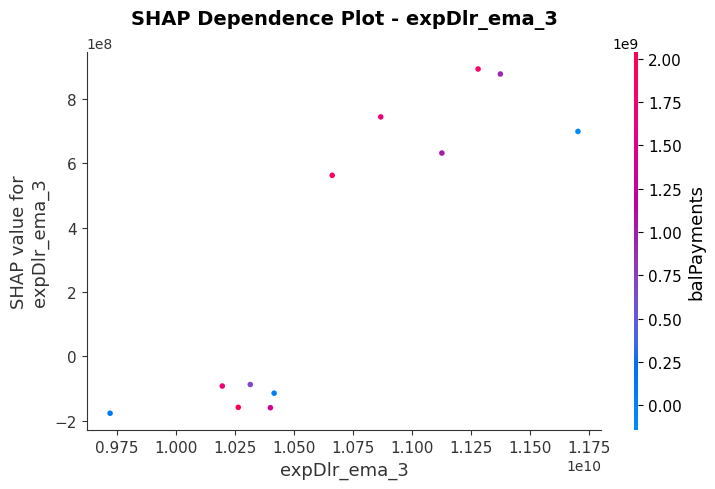


[시각화] SHAP Dependence Plot - distance_from_min_12m 생성 중...
✅ 저장 완료: shap_results/shap_dependence_distance_from_min_12m.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

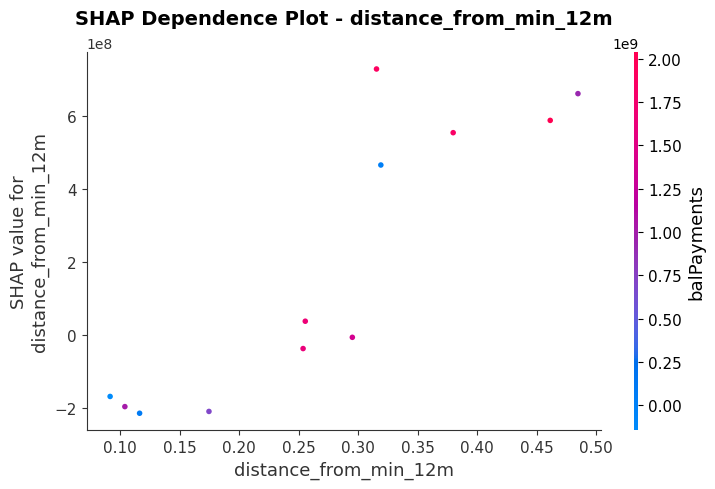


[시각화] SHAP Dependence Plot - distance_from_max_6m 생성 중...
✅ 저장 완료: shap_results/shap_dependence_distance_from_max_6m.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

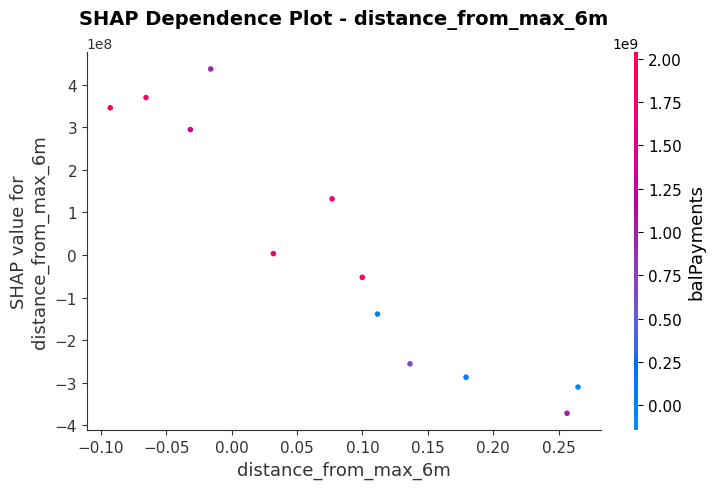


[시각화] SHAP Dependence Plot - distance_from_max_12m 생성 중...
✅ 저장 완료: shap_results/shap_dependence_distance_from_max_12m.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

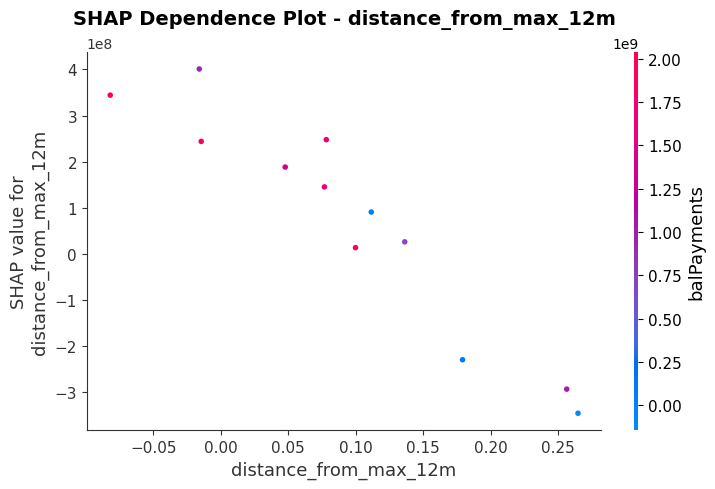


[시각화] SHAP Dependence Plot - distance_from_min_6m 생성 중...
✅ 저장 완료: shap_results/shap_dependence_distance_from_min_6m.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

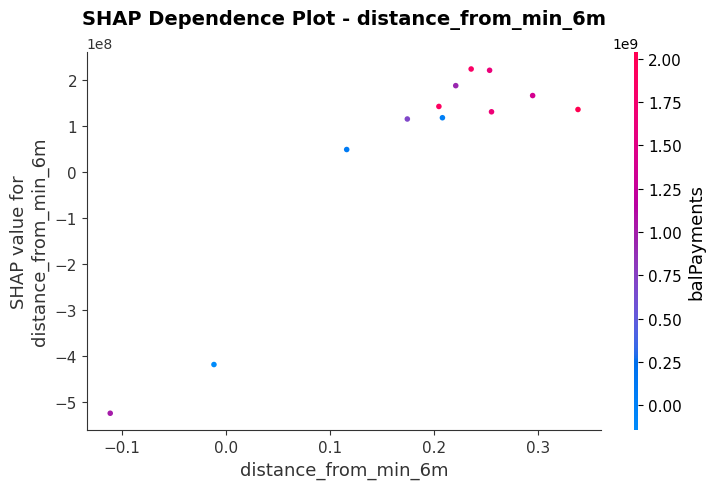


SHAP vs Traditional Feature Importance 비교

Top 20 Features 비교:
--------------------------------------------------------------------------------
Feature                              SHAP       Trad         차이
--------------------------------------------------------------------------------
expDlr_ema_3                       1.0000     1.0000    +0.0000
distance_from_min_12m              0.7461     0.2251    +0.5210
distance_from_max_6m               0.5784     0.2403    +0.3381
distance_from_max_12m              0.4952     0.3456    +0.1496
distance_from_min_6m               0.4700     0.1114    +0.3586
expDlr_ema_6                       0.2758     0.7921    -0.5163
expDlr                             0.2129     0.0798    +0.1331
impDlr                             0.1357     0.0633    +0.0724
expDlr_lag_1                       0.1203     0.1568    -0.0365
expWgt_sma_12                      0.0876     0.1581    -0.0706
expDlr_sma_12                      0.0815     0.0321    +0.0494
expWgt

<Figure size 640x480 with 0 Axes>

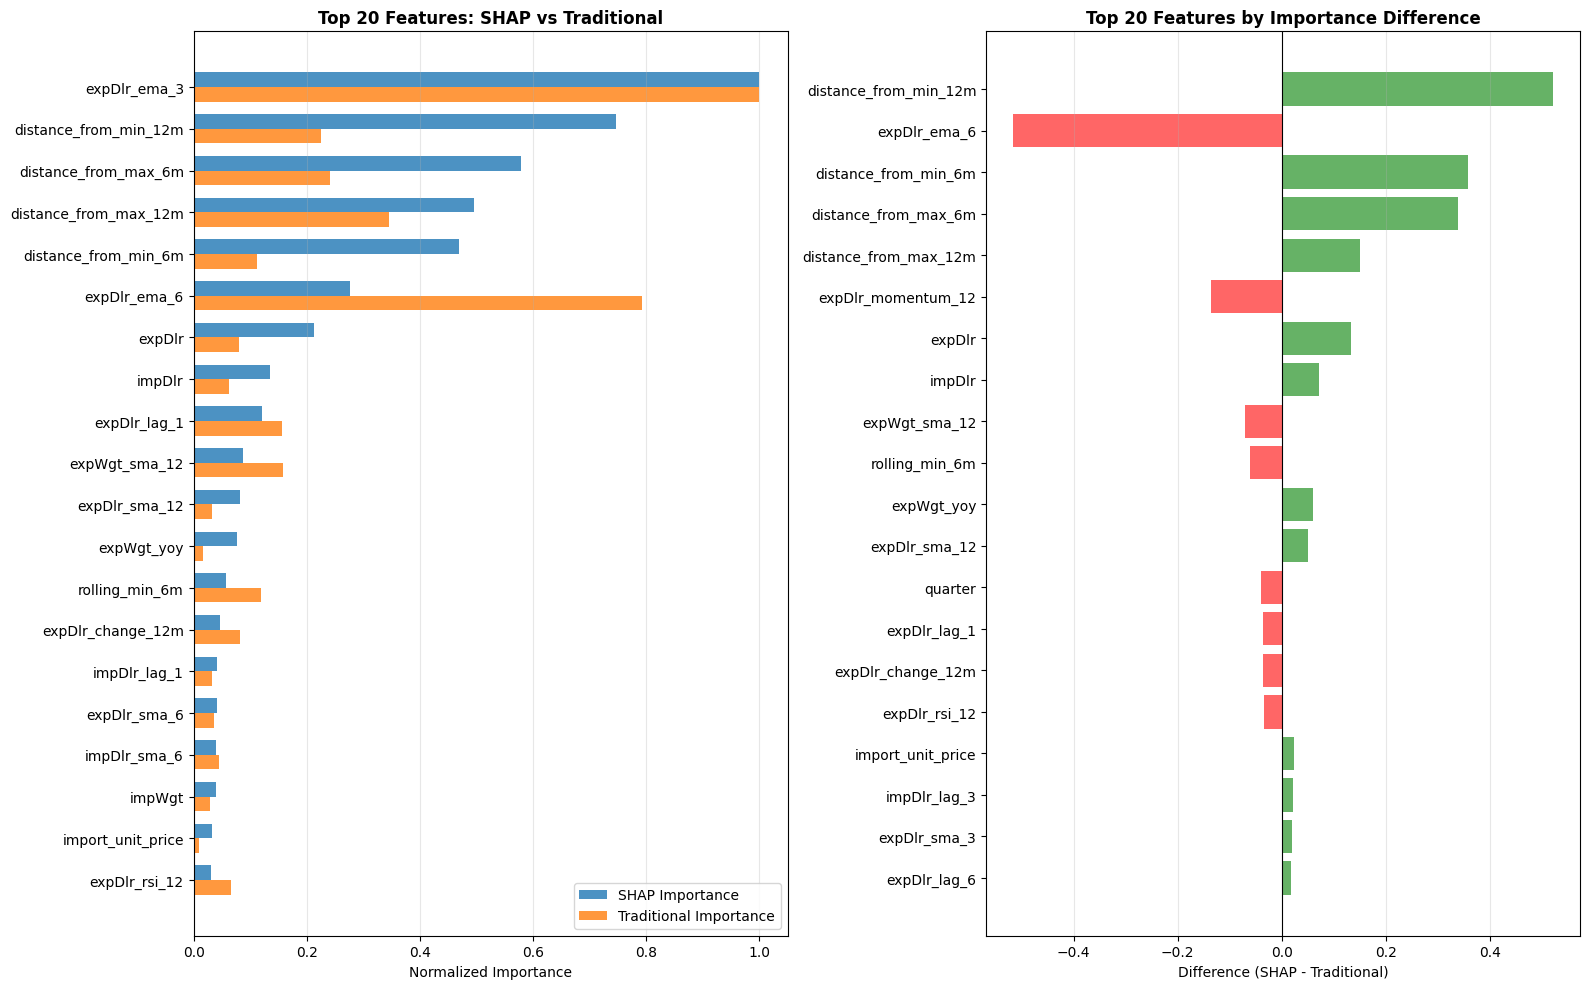


✅ Complete SHAP Analysis 완료!
✅ 결과 저장 위치: shap_results/


In [ ]:
if __name__ == "__main__":
    print("\n")
    print("="*80)
    print("SHAP Analysis - ITC Export Example")
    print("="*80)

    # 모델 및 데이터 준비 (이전 셀에서 정의됨)
    model = xgb_random.best_estimator_ # 튜닝된 XGBoost 모델
    X_train_shap = X_train # SHAP 분석용 X_train (이미 float64로 변환됨)
    X_test_shap = X_test # SHAP 분석용 X_test (이미 float64로 변환됨)
    feature_names = X.columns.tolist()

    # complete_shap_analysis 함수 실행
    results = complete_shap_analysis(
        model,
        X_train_shap,
        X_test_shap,
        feature_names,
        model_type='xgboost',
        output_dir='shap_results'
    )